In [1]:
import Pkg; Pkg.add("StatsBase")
import Pkg; Pkg.add("NamedArrays")
import Pkg; Pkg.add("PrettyTables")
import Pkg; Pkg.add("Shuffle")
import Pkg; Pkg.add("Zygote")
#import Pkg; Pkg.add("Plots.PlotMeasures")
import Pkg; Pkg.add("Metrics")
import Pkg; Pkg.add("ScikitLearn")
using DataFrames
using RDatasets
using Statistics
using StatsPlots
using CSV
using StatsBase
using NamedArrays
using PrettyTables
#using DecisionTree
using Shuffle
using Plots.PlotMeasures
using Zygote
using ScikitLearn.GridSearch: GridSearchCV
using ScikitLearn
using Metrics

include(joinpath(dirname(pwd()), "plottraintest.jl"))

fsize = 7
ftsize = 7

    Updating

 registry at `C:\Users\user\.julia\registries\General.toml`


   Resolving package versions...

  No Changes to `C:\Users\user\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\user\.julia\environments\v1.8\Manifest.toml`

   Resolving 

package versions...


  No Changes to `C:\Users\user\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\user\.julia\environments\v1.8\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\Users\user\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\user\.julia\environments\v1.8\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\Users\user\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\user\.julia\environments\v1.8\Manifest.toml`

   Resolving package versions...

  No Changes to `C:\Users\user\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\user\.julia\environments\v1.8\Manifest.toml`


   Resolving package versions...

  No Changes to `C:\Users\user\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\user\.julia\environments\v1.8\Manifest.toml`


   Resolving package versions...

  No Changes to `C:\Users\user\.julia\environments\v1.8\Project.toml`
  No Changes to `C:\Users\user\.julia\environments\v1.8\Manifest.toml`


7

In [2]:
df =  CSV.read(joinpath(dirname(@__FILE__), "Reg2.csv"), DataFrame)

,Cement,Blast_Furnace_Slag,Fly_Ash,Water,Water/Cement,Coarse_Aggregate,Fine_Aggregate
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,540.0,0.0,0.0,162.0,0.3,1040.0,676.0
2,540.0,0.0,0.0,162.0,0.3,1055.0,676.0
3,332.5,142.5,0.0,228.0,0.685714,932.0,594.0
4,332.5,142.5,0.0,228.0,0.685714,932.0,594.0
5,198.6,132.4,0.0,192.0,0.966767,978.4,825.5
6,266.0,114.0,0.0,228.0,0.857143,932.0,670.0
7,380.0,95.0,0.0,228.0,0.6,932.0,594.0
8,380.0,95.0,0.0,228.0,0.6,932.0,594.0
9,266.0,114.0,0.0,228.0,0.857143,932.0,670.0


In [3]:
dfm = Matrix(df)
dfms = dfm[shuffle(1:end), :]
# dfms = dfm

x = dfms[:, 1:8]
y = dfms[:, 9]

data_split = [0.6, 0.3, 0.1]
split_cs2 = Int.(round.(cumsum(data_split)*length(y)))
split_cs1 = vcat(1, split_cs2[1:(end-1)].+1)

xtrain = x[split_cs1[1]:split_cs2[1], :]
ytrain = y[split_cs1[1]:split_cs2[1]]

xtest = x[split_cs1[2]:split_cs2[2], :]
ytest = y[split_cs1[2]:split_cs2[2]]

xval = x[split_cs1[3]:split_cs2[3], :]
yval = y[split_cs1[3]:split_cs2[3]];

In [4]:
xnorm = (dfms[:, 1:8] .- mean(x,dims=1))./std(x,dims=1)
xtrainnorm = xnorm[split_cs1[1]:split_cs2[1], :]

xtestnorm = xnorm[split_cs1[2]:split_cs2[2], :]

xvalnorm = xnorm[split_cs1[3]:split_cs2[3], :];

In [5]:
function mse(ŷ::Vector{T}, y::Vector{T})::T where T<:AbstractFloat
	sum((ŷ-y).^2/length(ŷ))
end
function minimize!(f_model::Function, x::Matrix{T}, y::Vector{T}, p::Vector{T}, η::T, num_steps::Int)::Vector{T} where T<:AbstractFloat
	for step in 1:num_steps
		g(p) = mse(f_model(x, p), y)
		p .-= η.* g'(p)
	end
	p
end
function model(x::Matrix{T}, p::Vector{T})::Vector{T} where T<:AbstractFloat
	sum(x.*p[1:(length(p)-1)]', dims=2)[:] .+ p[length(p)]
end

model (generic function with 1 method)

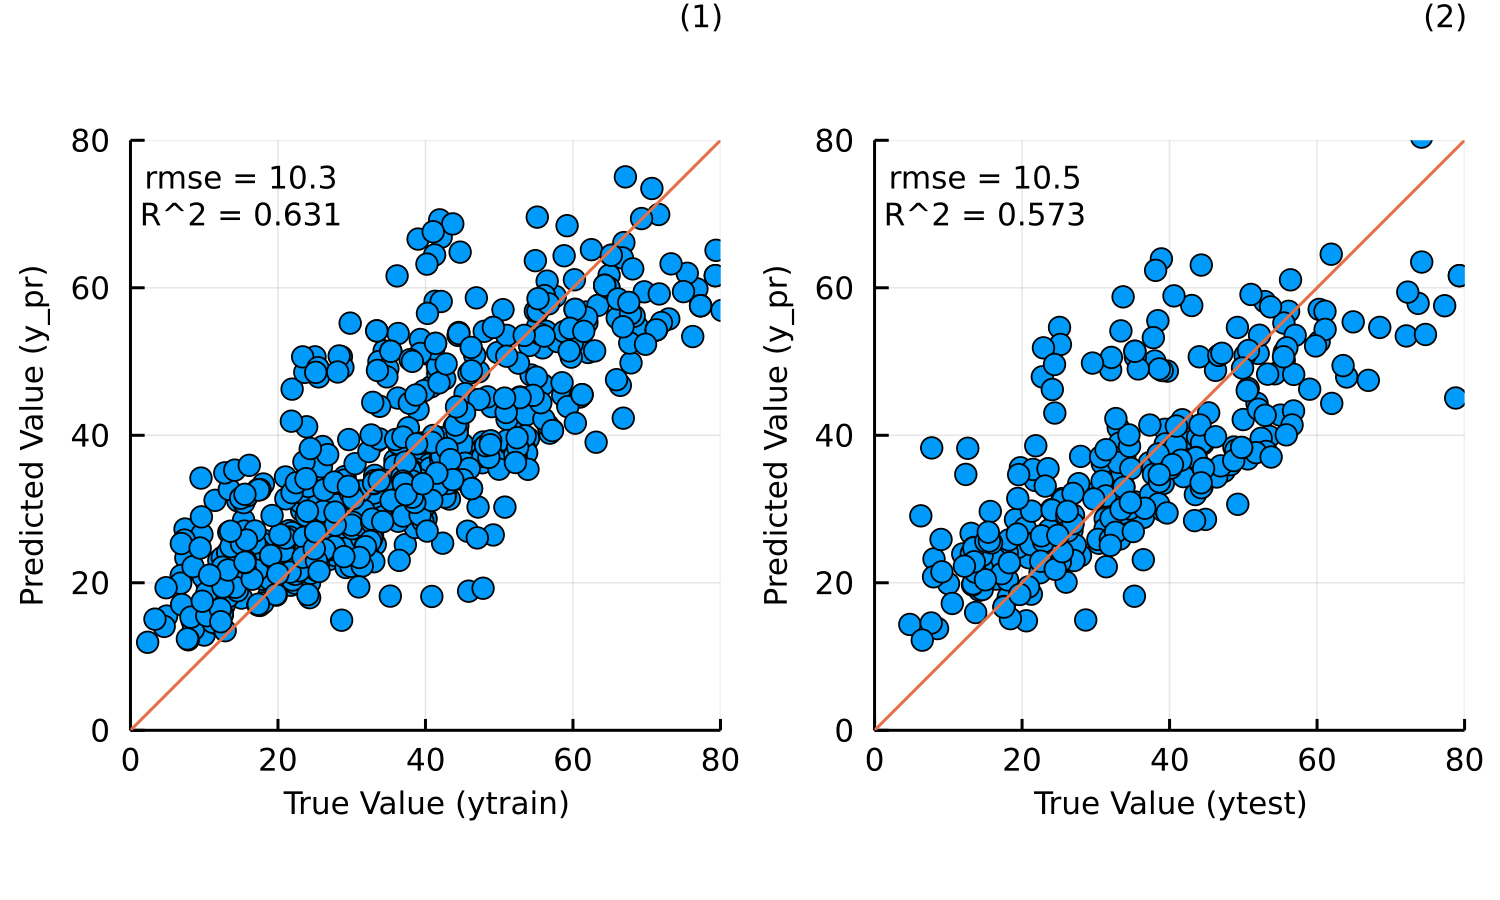

In [6]:
pp = minimize!(model, xtrain, ytrain, rand(size(x, 2)+1), 0.00000001, 10000000)  #0.000000001, 100000000
y_pr_train = model(xtrain, pp)
y_pr_test = model(xtest, pp)

display(plottraintest(ytrain, y_pr_train, ytest, y_pr_test))


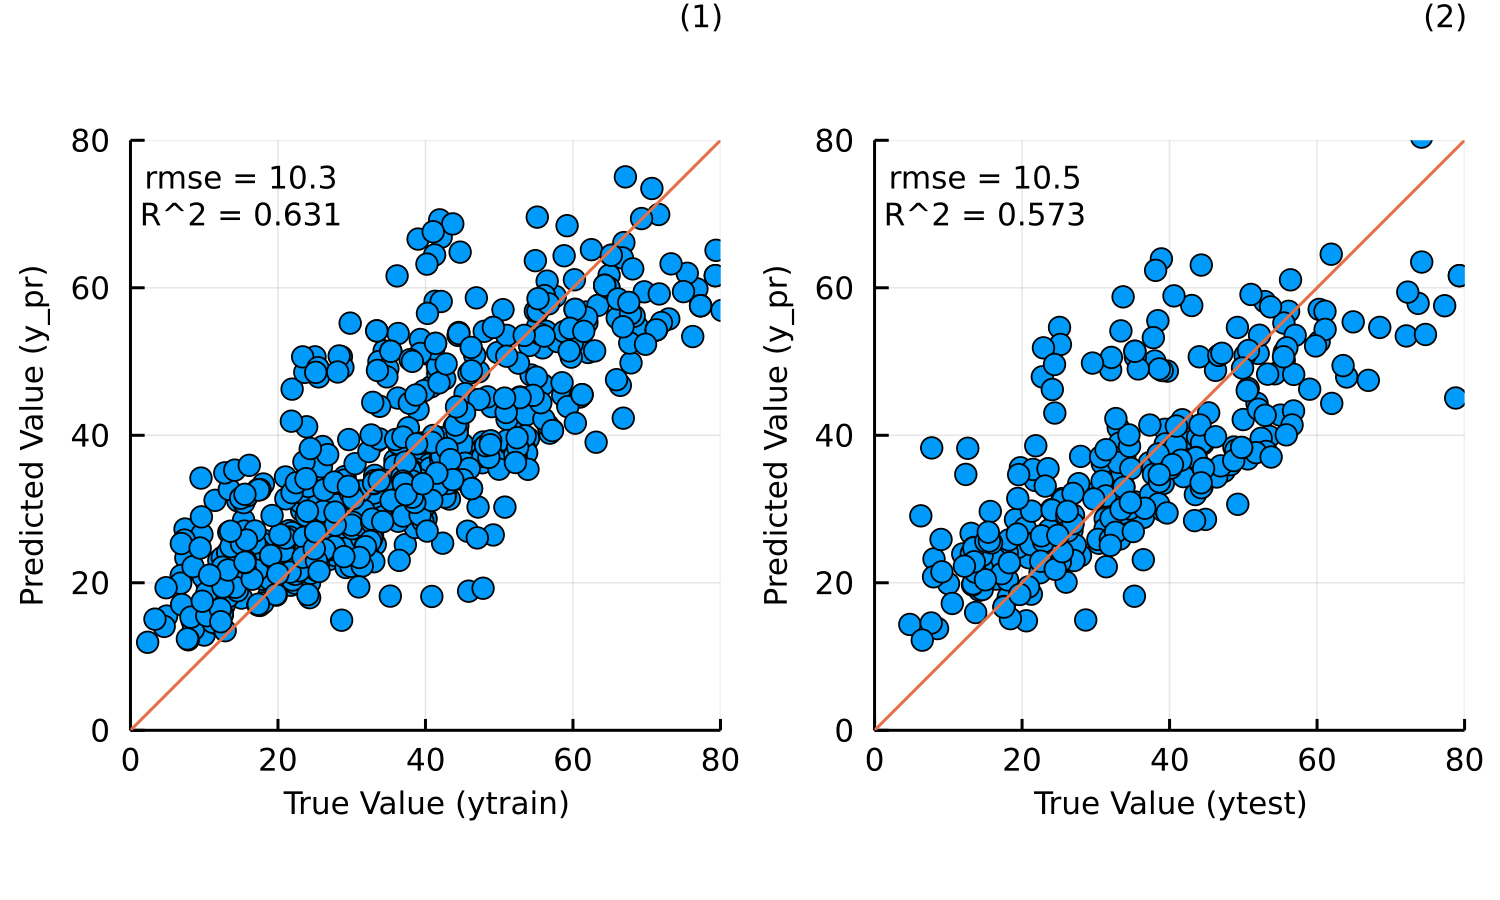

In [10]:
display(plottraintest(ytrain, y_pr_train, ytest, y_pr_test))
savefig(joinpath(dirname(@__FILE__), "Regression.png")) # uncomment to save figure
# CSV.write("Regression.csv", DataFrame(p=pp), header=false) # uncomment to save p to csv

In [8]:
#p_norm = minimize!(model, xtrainnorm, ytrain, rand(size(x, 2)+1), 0.00001, 100000)
#y_pr_trainnorm = model(xtrainnorm, p_norm)
#y_pr_testnorm = model(xtestnorm, p_norm)

#display(plottraintest(ytrain, y_pr_trainnorm, ytest, y_pr_testnorm))

In [9]:
#dfp = CSV.read(joinpath(dirname(@__FILE__), "Regression.csv"), DataFrame)
#ppp = Matrix(dfp)[:]

#y_pr_train = model(xtrain, ppp)
#y_pr_test = model(xtest, ppp)

#display(plottraintest(ytrain, y_pr_train, ytest, y_pr_test))